In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Load the data

In [4]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [5]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [6]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


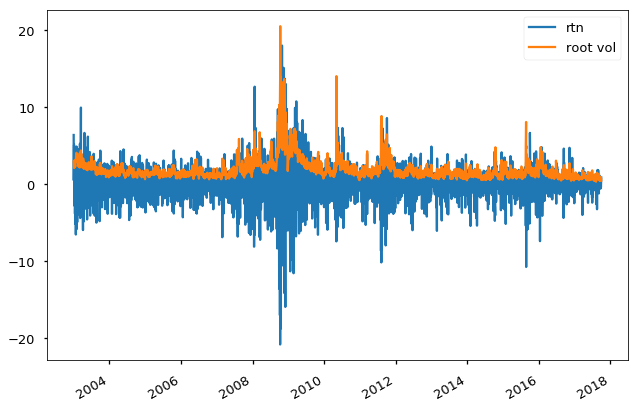

In [7]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

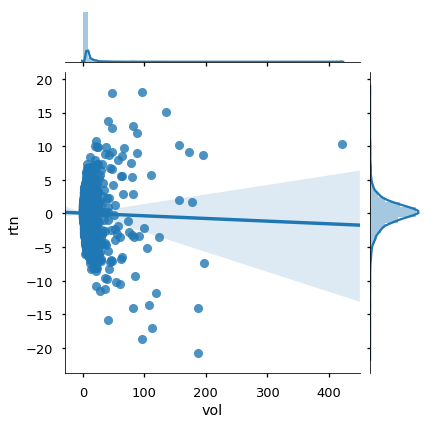

In [8]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [9]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [10]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016,
 'phi': -0.3021332298877708,
 'pi': -0.35969605398014043,
 'theta': 0.5278630825503945}

In [11]:
omega_cov

,beta,delta,gamma,phi,pi,psi,rho,scale,theta,zeta
beta,0.000097,0.000000,-0.000035,NaN,NaN,-0.000091,0.000000,0.000000,NaN,0.000000
delta,0.000000,1.953968,0.000000,NaN,NaN,0.000000,-0.275013,-2.536490,NaN,0.000000
gamma,-0.000035,0.000000,0.000648,NaN,NaN,-0.000080,0.000000,0.000000,NaN,0.000000
phi,NaN,NaN,NaN,9.592997,-2.714527,NaN,NaN,NaN,4.126216,NaN
pi,NaN,NaN,NaN,-2.714527,0.781588,NaN,NaN,NaN,-1.164330,NaN
psi,-0.000091,0.000000,-0.000080,NaN,NaN,0.000149,0.000000,0.000000,NaN,0.000000
rho,0.000000,-0.275013,0.000000,NaN,NaN,0.000000,0.042748,0.326903,NaN,0.000000
scale,0.000000,-2.536490,0.000000,NaN,NaN,0.000000,0.326903,4.739982,NaN,0.000000
theta,NaN,NaN,NaN,4.126216,-1.164330,NaN,NaN,NaN,1.775765,NaN
zeta,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000431


In [12]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [13]:
omega2, omega_cov2 = vl.estimate_params(data)

In [14]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=3, pi_dim=3, phi_dim=3,
                                 pi_min=-3, pi_max=0, theta_min=0, theta_max=2, use_tqdm=True, case=1)


In [15]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016,
 'phi': -0.3021332298877708,
 'pi': -0.35969605398014043,
 'theta': 0.5278630825503945}

In [16]:
vl.qlr_sim([-.3, -.35, 0.53], omega2, omega_cov2, innov_dim=4,case=1, alpha=0.05)


(-0.3, -0.35, 0.53, 3.103575770021403)

In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                               innov_dim=20,pi_min=-3, pi_max=0, theta_min=0, theta_max=2,  use_tqdm=True, alpha=0.05)

In [40]:
qlr_stats.head()

,phi,pi,theta,qlr
0,-0.9,-3.0,2.0,inf
1,-0.9,-3.0,0.0,inf
2,-0.9,-1.5,1.0,inf
3,-0.9,-3.0,1.0,inf
4,-0.9,-1.5,2.0,inf


In [39]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.9,-1.5,1.0,0.0
1,-0.9,-1.5,0.0,0.0
2,-0.9,-3.0,0.0,0.0
3,-0.9,-3.0,2.0,0.0
4,-0.9,0.0,1.0,0.0


In [33]:
qlr_draws.to_json('../results/qlr_draws_on_data.tmp.json')

In [58]:
accepted_vals = pd.merge(qlr_draws, qlr_stats, right_on=['phi', 'pi', 'theta'], left_on=['phi', 'pi', 'theta'],
         how='outer', suffixes=['_draws', '_stats']).query('qlr_stats < qlr_draws').drop(
    ['qlr_draws', 'qlr_stats'], axis='columns')

In [60]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [61]:
accepted_vals

,phi,pi,theta


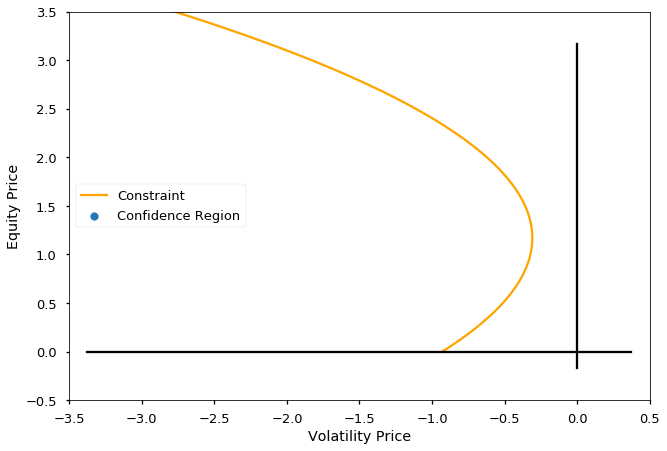

In [63]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=60, label='Confidence Region')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,5,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='orange', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.legend()
ax3.set_ylabel('Equity Price')
ax3.set_xlabel('Volatility Price')
fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [64]:
accepted_vals.min()

phi     NaN
pi      NaN
theta   NaN
dtype: float64

In [65]:
accepted_vals.max()

phi     NaN
pi      NaN
theta   NaN
dtype: float64